In [71]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
import os
import pandas as pd
import datetime
sns.set_style("whitegrid")
from matplotlib.ticker import NullFormatter
from matplotlib.dates import DateFormatter
from matplotlib.ticker import MultipleLocator
from matplotlib.dates import MonthLocator

# customized settings
params = {  # 'backend': 'ps',
    'font.family': 'serif',
    'font.serif': 'Latin Modern Roman',
    'font.size': 12,
    'axes.labelsize': 'medium',
    'axes.titlesize': 'medium',
    'legend.fontsize': 'medium',
    'xtick.labelsize': 'small',
    'ytick.labelsize': 'small',
    'savefig.dpi': 150,
    'text.usetex': True}
# tell matplotlib about your params
rcParams.update(params)

# set nice figure sizes
fig_width_pt = 468    # Get this from LaTeX using \showthe\columnwidth
golden_mean = (np.sqrt(5.) - 1.) / 2.  # Aesthetic ratio
ratio = golden_mean
inches_per_pt = 1. / 72.27  # Convert pt to inches
fig_width = fig_width_pt * inches_per_pt  # width in inches
fig_height = fig_width*ratio  # height in inches
fig_size = [fig_width, fig_height]
rcParams.update({'figure.figsize': fig_size})

In [72]:
def extract_forecasts(data, forecast_period):
    
    dates = []
    forecast_dates = []
    data_quantile_0025_cont = []
    data_quantile_0975_cont = []
    data_point_cont = []
    
    for file in sorted(os.listdir(ensemble_forecast_directory))[7:]:    

        if file[-4:] == '.csv':
            
            data = pd.read_csv(ensemble_forecast_directory+file)
            
            data = data[data['location'] == 'US']
                
            data_quantile = data[data['type'] == 'quantile']
                        
            data_quantile_0025 = data[data['quantile'] == 0.025]    
            data_quantile_0975 = data[data['quantile'] == 0.975]     
            
            data_point = data[data['type'] == 'point']
            
            forecast_dates.append(data_quantile_0025[data_quantile_0025['target'] == forecast_period]['forecast_date'].to_numpy()[0])
            dates.append(data_quantile_0025[data_quantile_0025['target'] == forecast_period]['target_end_date'].to_numpy()[0])
            data_quantile_0025_cont.append(float(data_quantile_0025[data_quantile_0025['target'] == forecast_period]['value']))
            data_quantile_0975_cont.append(float(data_quantile_0975[data_quantile_0975['target'] == forecast_period]['value']))
            data_point_cont.append(float(data_point[data_point['target'] == forecast_period]['value']))
    
    dates = [datetime.datetime.strptime(date, '%Y-%m-%d') for date in dates]
    forecast_dates = [datetime.datetime.strptime(date, '%Y-%m-%d') for date in forecast_dates]
    
    return np.asarray(forecast_dates), np.asarray(dates), np.asarray(data_quantile_0025_cont), np.asarray(data_quantile_0975_cont), np.asarray(data_point_cont)

In [73]:
def error_comparison(deaths_covid_data, data_point, forecast_dates, dates, dates_covid_data, week):
    error_euler = []
    error_ensemble = []
    
    rate_of_change = []
    euler_prediction_arr = []
    rate_of_change_dates = []
    euler_prediction_dates = []

    for i in range(len(dates)):
        
        ind = np.where(dates_covid_data == dates[i])
            
        if len(ind[0]):
            ind = ind[0][0]
            
            current_rate_of_change = deaths_covid_data[ind]-deaths_covid_data[ind-6]

            ind2 = np.where(dates_covid_data == forecast_dates[i])[0][0]
            euler_prediction = deaths_covid_data[ind2-1]-deaths_covid_data[ind2-1-6]
            print(euler_prediction, dates_covid_data[ind2-1], dates_covid_data[ind2-1-6], dates_covid_data[ind], dates_covid_data[ind-6])
            
            euler_prediction_arr.append(euler_prediction)
            rate_of_change.append(current_rate_of_change)
            rate_of_change_dates.append(forecast_dates[i])
            euler_prediction_dates.append(dates[i])

            error_euler.append(abs(euler_prediction-current_rate_of_change))
            error_ensemble.append(abs(data_point[i]-current_rate_of_change))
      
    error_euler = np.asarray(error_euler)/div  
    error_ensemble = np.asarray(error_ensemble)/div    
    error_euler_cum = np.cumsum(error_euler)
    error_ensemble_cum = np.cumsum(error_ensemble)
    
    rate_of_change = np.array(rate_of_change)
    rate_of_change_dates = np.array(rate_of_change_dates)
    euler_prediction_arr = np.array(euler_prediction_arr)
    euler_prediction_dates = np.array(euler_prediction_dates)

    return rate_of_change, rate_of_change_dates, euler_prediction_arr, euler_prediction_dates, error_euler, error_ensemble, error_euler_cum, error_ensemble_cum

In [74]:
covid_data = pd.read_csv('../../data/Covid19_ground_truth_reports/fetched_Jan_2022/time_series_covid19_deaths_US.csv')

colnames = covid_data.columns.tolist()

start = datetime.datetime.strptime(colnames[12], "%m/%d/%y")
end = datetime.datetime.strptime(colnames[-1], "%m/%d/%y")
dates_covid_data = np.asarray([start + datetime.timedelta(days=x) for x in range(0,(end-start).days+1)])
deaths_covid_data = [covid_data.iloc[:,i].sum() for i in range(12,len(colnames))]
deaths_covid_data = np.array(deaths_covid_data)

In [75]:
ensemble_forecast_directory = '../../data/CDC_ensemble_forecasts/fetched_Jan_2022/COVIDhub-ensemble/'
    
forecast_dates_1wk, dates_1wk, data_quantile_0025_1wk, data_quantile_0975_1wk, data_point_1wk = \
extract_forecasts(ensemble_forecast_directory, '1 wk ahead inc death')

forecast_dates_4wk, dates_4wk, data_quantile_0025_4wk, data_quantile_0975_4wk, data_point_4wk = \
extract_forecasts(ensemble_forecast_directory, '4 wk ahead inc death')

div = 1e3

In [76]:
rate_of_change_1wk, rate_of_change_dates_1wk, euler_prediction_arr_1wk, euler_prediction_dates_1wk, error_euler_1wk, error_ensemble_1wk, error_euler_1wk_cum, error_ensemble_1wk_cum = \
error_comparison(deaths_covid_data, data_point_1wk, forecast_dates_1wk, dates_1wk, dates_covid_data, 1)
rate_of_change_4wk, rate_of_change_dates_4wk, euler_prediction_arr_4wk, euler_prediction_dates_4wk, error_euler_4wk, error_ensemble_4wk, error_euler_4wk_cum, error_ensemble_4wk_cum = \
error_comparison(deaths_covid_data, data_point_4wk, forecast_dates_4wk, dates_4wk, dates_covid_data, 4)

4970 2020-06-07 00:00:00 2020-06-01 00:00:00 2020-06-13 00:00:00 2020-06-07 00:00:00
4498 2020-06-14 00:00:00 2020-06-08 00:00:00 2020-06-20 00:00:00 2020-06-14 00:00:00
3749 2020-06-21 00:00:00 2020-06-15 00:00:00 2020-06-27 00:00:00 2020-06-21 00:00:00
3485 2020-06-28 00:00:00 2020-06-22 00:00:00 2020-07-04 00:00:00 2020-06-28 00:00:00
3297 2020-07-05 00:00:00 2020-06-29 00:00:00 2020-07-11 00:00:00 2020-07-05 00:00:00
5057 2020-07-12 00:00:00 2020-07-06 00:00:00 2020-07-18 00:00:00 2020-07-12 00:00:00
5095 2020-07-19 00:00:00 2020-07-13 00:00:00 2020-07-25 00:00:00 2020-07-19 00:00:00
6004 2020-07-26 00:00:00 2020-07-20 00:00:00 2020-08-01 00:00:00 2020-07-26 00:00:00
6710 2020-08-02 00:00:00 2020-07-27 00:00:00 2020-08-08 00:00:00 2020-08-02 00:00:00
6794 2020-08-09 00:00:00 2020-08-03 00:00:00 2020-08-15 00:00:00 2020-08-09 00:00:00
6612 2020-08-16 00:00:00 2020-08-10 00:00:00 2020-08-22 00:00:00 2020-08-16 00:00:00
6192 2020-08-23 00:00:00 2020-08-17 00:00:00 2020-08-29 00:00:00 

In [77]:
euler_lagrange_1wk_data = pd.read_csv("../../results/fetched_Jan_2022/US/fetched_Jan_2022_error_euler_langrange_cdc_week_1.csv")
euler_lagrange_4wk_data = pd.read_csv("../../results/fetched_Jan_2022/US/fetched_Jan_2022_error_euler_langrange_cdc_week_4.csv")

euler_lagrange_1wk_dates = pd.to_datetime(euler_lagrange_1wk_data["target_prediction_date"]).to_numpy()
euler_lagrange_1wk_prediction = euler_lagrange_1wk_data["euler_prediction_value"].to_numpy()
euler_lagrange_1wk_error = euler_lagrange_1wk_data["error_euler"].to_numpy()
euler_lagrange_4wk_dates = pd.to_datetime(euler_lagrange_4wk_data["target_prediction_date"]).to_numpy()
euler_lagrange_4wk_prediction = euler_lagrange_4wk_data["euler_prediction_value"].to_numpy()
euler_lagrange_4wk_error = euler_lagrange_4wk_data["error_euler"].to_numpy()

In [78]:
rolling_mean_1wk_euler_lagrange = euler_lagrange_1wk_data.rolling(window=4)['error_euler'].mean()
rolling_mean_4wk_euler_lagrange = euler_lagrange_4wk_data.rolling(window=4)['error_euler'].mean()

df = pd.DataFrame()
df["error_ensemble"] = error_ensemble_1wk
rolling_mean_1wk_CDC = df.rolling(window=4)['error_ensemble'].mean()
df = pd.DataFrame()
df["error_ensemble"] = error_ensemble_4wk
rolling_mean_4wk_CDC = df.rolling(window=4)['error_ensemble'].mean()

df = pd.DataFrame()
df["error_ensemble"] = error_euler_1wk
rolling_mean_1wk_euler = df.rolling(window=4)['error_ensemble'].mean()
df = pd.DataFrame()
df["error_ensemble"] = error_euler_4wk
rolling_mean_4wk_euler = df.rolling(window=4)['error_ensemble'].mean()

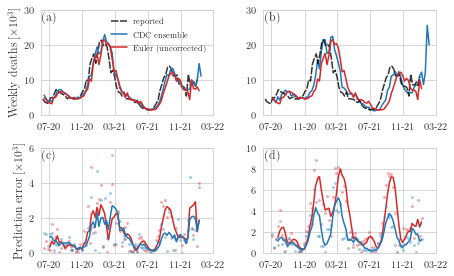

In [85]:
fig, ax = plt.subplots(nrows=2,ncols=2)
ax[0,0].text(dates_1wk[0]-datetime.timedelta(days=7), 0.9*30, r'(a)')
ax[0,0].plot(rate_of_change_dates_1wk, rate_of_change_1wk/div, ls = (0, (5, 1)), color = 'k', linewidth = 1.5, alpha = 0.8, label = r'reported')
#ax[0,0].fill_between(dates_1wk, data_quantile_0975_1wk/div, data_quantile_0025_1wk/div, facecolor = 'tab:blue', alpha = 0.3)
ax[0,0].plot(dates_1wk, data_point_1wk/div, color = 'tab:blue', linewidth = 1.5, label=r"CDC ensemble")
ax[0,0].plot(euler_prediction_dates_1wk, euler_prediction_arr_1wk/div, color = "tab:red", label=r"Euler (uncorrected)")
ax[0,0].set_xlim([datetime.date(2020, 6, 1), datetime.date(2022, 3, 1)])
ax[0,0].tick_params(axis='x', labelrotation=0)
ax[0,0].xaxis.set_major_locator(MonthLocator([3,7,11]))
ax[0,0].set_ylabel(r'Weekly deaths [$\times 10^3$]')
ax[0,0].xaxis.set_major_formatter(DateFormatter("%m-%y"))
ax[0,0].set_ylim(0,30)
ax[0,0].legend(loc=1,frameon=False,fontsize=8)

ax[0,1].text(dates_1wk[0]-datetime.timedelta(days=7), 0.9*30, r'(b)')
#ax[0,1].fill_between(dates_4wk, data_quantile_0975_4wk/div, data_quantile_0025_4wk/div, facecolor = 'tab:blue', alpha = 0.3)
ax[0,1].plot(dates_4wk, data_point_4wk/div, color = 'tab:blue', linewidth = 1.5)
ax[0,1].plot(rate_of_change_dates_1wk, rate_of_change_1wk/div, ls = (0, (5, 1)), color = 'k', linewidth = 1.5, alpha = 0.8)
ax[0,1].plot(euler_prediction_dates_4wk, euler_prediction_arr_4wk/div, color = "tab:red")
ax[0,1].set_xlim([datetime.date(2020, 6, 1), datetime.date(2022, 3, 1)])
ax[0,1].xaxis.set_major_locator(MonthLocator([3,7,11]))
ax[0,1].xaxis.set_major_formatter(DateFormatter("%m-%y"))
ax[0,1].set_ylim(0,30)

ax[1,0].text(dates_1wk[0]-datetime.timedelta(days=7), 0.9*6, r'(c)')
ax[1,0].plot(euler_prediction_dates_1wk,error_euler_1wk, color = 'tab:red', linewidth = 1.5, ls = "None", marker=".", markersize=4, alpha=0.3)   
ax[1,0].plot(euler_prediction_dates_1wk,rolling_mean_1wk_euler, color = 'tab:red', linewidth = 1.5)   
#ax[1,0].plot(rate_of_change_dates_1wk,error_euler_1wk_cum, color = 'tab:red', ls = (0, (5, 1)), linewidth = 1.5) 
ax[1,0].plot(euler_prediction_dates_1wk,error_ensemble_1wk, color = 'tab:blue', linewidth = 1.5, ls = "None", marker=".", markersize=4, alpha=0.3)  
ax[1,0].plot(euler_prediction_dates_1wk,rolling_mean_1wk_CDC, color = 'tab:blue', linewidth = 1.5)  
#ax[1,0].plot(rate_of_change_dates_1wk,error_ensemble_1wk_cum, color = 'tab:blue', ls = (0, (5, 1)), linewidth = 1.5)  
ax[1,0].set_xlim([datetime.date(2020, 6, 1), datetime.date(2022, 3, 1)])
ax[1,0].tick_params(axis='x', labelrotation=0)
ax[1,0].xaxis.set_major_locator(MonthLocator([3,7,11]))
ax[1,0].xaxis.set_major_formatter(DateFormatter("%m-%y"))
ax[1,0].set_ylabel(r'Prediction error [$\times 10^3$]')
ax[1,0].set_ylim(0,6)

ax[1,1].text(dates_1wk[0]-datetime.timedelta(days=7), 0.9*10, r'(d)')
ax[1,1].plot(euler_prediction_dates_4wk,error_euler_4wk, color = 'tab:red', linewidth = 1.5, ls = "None", marker=".", markersize=4, alpha=0.3)  
ax[1,1].plot(euler_prediction_dates_4wk,rolling_mean_4wk_euler, color = 'tab:red', linewidth = 1.5)  
#ax[1,1].plot(rate_of_change_dates_4wk,error_euler_4wk_cum, color = 'tab:red', ls = (0, (5, 1)), linewidth = 1.5) 
ax[1,1].plot(euler_prediction_dates_4wk,error_ensemble_4wk, color = 'tab:blue', linewidth = 1.5, ls = "None", marker=".", markersize=4, alpha=0.3)  
ax[1,1].plot(euler_prediction_dates_4wk,rolling_mean_4wk_CDC, color = 'tab:blue', linewidth = 1.5)  
#ax[1,1].plot(rate_of_change_dates_4wk,error_ensemble_4wk_cum, color = 'tab:blue', ls = (0, (5, 1)), linewidth = 1.5)  
ax[1,1].set_xlim([datetime.date(2020, 6, 1), datetime.date(2022, 3, 1)])
ax[1,1].tick_params(axis='x', labelrotation=0)
ax[1,1].xaxis.set_major_locator(MonthLocator([3,7,11]))
ax[1,1].xaxis.set_major_formatter(DateFormatter("%m-%y"))
ax[1,1].set_ylim(0,10)

plt.tight_layout()
plt.margins(0,0)
plt.savefig("euler_cdc_comparison_fetched_Jan_2022_US.png", dpi = 300, bbox_inches = 'tight', pad_inches = 0.05)
plt.show()

In [80]:
print("Euler--Lagrange cumulative error 1wk:", sum(error_euler_1wk))
print("CDC error 1wk:", sum(error_ensemble_1wk))
print("Euler--Lagrange cumulative error 4wk:", sum(error_euler_4wk))
print("CDC error 4wk:", sum(error_ensemble_4wk))

Euler--Lagrange cumulative error 1wk: 97.87000000000002
CDC error 1wk: 83.85899826747566
Euler--Lagrange cumulative error 4wk: 236.65
CDC error 4wk: 132.0136885578389


In [81]:
sum(error_euler_1wk < error_ensemble_1wk)/len(euler_arr)

NameError: name 'euler_arr' is not defined

In [ ]:
print("Euler--Lagrange cumulative error 1wk:", sum(euler_lagrange_1wk_error))
print("CDC error 1wk:", sum(euler_lagrange_1wk_data["error_cdc_ensemble"].to_numpy()))
print("Euler--Lagrange cumulative error 4wk:", sum(euler_lagrange_4wk_error))
print("CDC error 4wk:", sum(euler_lagrange_4wk_data["error_cdc_ensemble"].to_numpy()))

In [ ]:
euler_arr = euler_lagrange_1wk_error/div
sum(euler_arr < error_ensemble_1wk)/len(euler_arr)

In [ ]:
rolling_mean_1wk_euler_lagrange = euler_lagrange_1wk_data.rolling(window=4)['error_euler'].mean()
rolling_mean_4wk_euler_lagrange = euler_lagrange_4wk_data.rolling(window=4)['error_euler'].mean()

df = pd.DataFrame()
df["error_ensemble"] = error_ensemble_1wk
rolling_mean_1wk_CDC = df.rolling(window=4)['error_ensemble'].mean()
df = pd.DataFrame()
df["error_ensemble"] = error_ensemble_4wk
rolling_mean_4wk_CDC = df.rolling(window=4)['error_ensemble'].mean()

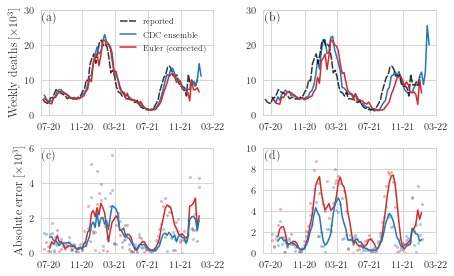

In [83]:
fig, ax = plt.subplots(nrows=2,ncols=2)
ax[0,0].text(dates_1wk[0]-datetime.timedelta(days=7), 0.9*30, r'(a)')
ax[0,0].plot(rate_of_change_dates_1wk, rate_of_change_1wk/div, ls = (0, (5, 1)), color = 'k', linewidth = 1.5, alpha = 0.8, label = r'reported')
#ax[0,0].fill_between(dates_1wk, data_quantile_0975_1wk/div, data_quantile_0025_1wk/div, facecolor = 'tab:blue', alpha = 0.3)
ax[0,0].plot(dates_1wk, data_point_1wk/div, color = 'tab:blue', linewidth = 1.5, label=r"CDC ensemble")
ax[0,0].plot(euler_lagrange_1wk_dates,euler_lagrange_1wk_prediction/div, color = "tab:red", label=r"Euler (corrected)")
ax[0,0].set_xlim([datetime.date(2020, 6, 1), datetime.date(2022, 3, 1)])
ax[0,0].tick_params(axis='x', labelrotation=0)
ax[0,0].set_ylabel(r'Weekly deaths [$\times 10^3$]')
ax[0,0].xaxis.set_major_locator(MonthLocator([3,7,11]))
ax[0,0].xaxis.set_major_formatter(DateFormatter("%m-%y"))
ax[0,0].set_ylim(0,30)
ax[0,0].legend(loc=1,frameon=False,fontsize=8)

ax[0,1].text(dates_1wk[0]-datetime.timedelta(days=7), 0.9*30, r'(b)')
#ax[0,1].fill_between(dates_4wk, data_quantile_0975_4wk/div, data_quantile_0025_4wk/div, facecolor = 'tab:blue', alpha = 0.3)
ax[0,1].plot(dates_4wk, data_point_4wk/div, color = 'tab:blue', linewidth = 1.5)
ax[0,1].plot(rate_of_change_dates_1wk, rate_of_change_1wk/div, ls = (0, (5, 1)), color = 'k', linewidth = 1.5, alpha = 0.8)
ax[0,1].plot(euler_lagrange_4wk_dates,euler_lagrange_4wk_prediction/div, color = "tab:red")
ax[0,1].set_xlim([datetime.date(2020, 6, 1), datetime.date(2022, 3, 1)])
ax[0,1].xaxis.set_major_locator(MonthLocator([3,7,11]))
ax[0,1].xaxis.set_major_formatter(DateFormatter("%m-%y"))
ax[0,1].set_ylim(0,30)

ax[1,0].text(dates_1wk[0]-datetime.timedelta(days=7), 0.9*6, r'(c)')
ax[1,0].plot(euler_lagrange_1wk_dates,euler_lagrange_1wk_error/div, color = 'tab:red', linewidth = 1.5, ls = "None", marker=".", markersize=4, alpha=0.3)   
ax[1,0].plot(euler_lagrange_1wk_dates,rolling_mean_1wk_euler_lagrange/div, color = 'tab:red', linewidth = 1.5)   
#ax[1,0].plot(rate_of_change_dates_1wk,error_euler_1wk_cum, color = 'tab:red', ls = (0, (5, 1)), linewidth = 1.5) 
ax[1,0].plot(euler_prediction_dates_1wk,error_ensemble_1wk, color = 'tab:blue', linewidth = 1.5, ls = "None", marker=".", markersize=4, alpha=0.3)  
ax[1,0].plot(euler_prediction_dates_1wk,rolling_mean_1wk_CDC, color = 'tab:blue', linewidth = 1.5)  
#ax[1,0].plot(rate_of_change_dates_1wk,error_ensemble_1wk_cum, color = 'tab:blue', ls = (0, (5, 1)), linewidth = 1.5)  
ax[1,0].set_xlim([datetime.date(2020, 6, 1), datetime.date(2022, 3, 1)])
ax[1,0].tick_params(axis='x', labelrotation=0)
ax[1,0].xaxis.set_major_locator(MonthLocator([3,7,11]))
ax[1,0].xaxis.set_major_formatter(DateFormatter("%m-%y"))
ax[1,0].set_ylabel(r'Absolute error [$\times 10^3$]')
ax[1,0].set_ylim(0,6)

ax[1,1].text(dates_1wk[0]-datetime.timedelta(days=7), 0.9*10, r'(d)')
ax[1,1].plot(euler_lagrange_4wk_dates,euler_lagrange_4wk_error/div, color = 'tab:red', linewidth = 1.5, ls = "None", marker=".", markersize=4, alpha=0.3)  
ax[1,1].plot(euler_lagrange_4wk_dates,rolling_mean_4wk_euler_lagrange/div, color = 'tab:red', linewidth = 1.5)  
#ax[1,1].plot(rate_of_change_dates_4wk,error_euler_4wk_cum, color = 'tab:red', ls = (0, (5, 1)), linewidth = 1.5) 
ax[1,1].plot(euler_prediction_dates_4wk,error_ensemble_4wk, color = 'tab:blue', linewidth = 1.5, ls = "None", marker=".", markersize=4, alpha=0.3)  
ax[1,1].plot(euler_prediction_dates_4wk,rolling_mean_4wk_CDC, color = 'tab:blue', linewidth = 1.5)  
#ax[1,1].plot(rate_of_change_dates_4wk,error_ensemble_4wk_cum, color = 'tab:blue', ls = (0, (5, 1)), linewidth = 1.5)  
ax[1,1].set_xlim([datetime.date(2020, 6, 1), datetime.date(2022, 3, 1)])
ax[1,1].tick_params(axis='x', labelrotation=0)
ax[1,1].xaxis.set_major_locator(MonthLocator([3,7,11]))
ax[1,1].xaxis.set_major_formatter(DateFormatter("%m-%y"))
ax[1,1].set_ylim(0,10)

plt.tight_layout()
plt.margins(0,0)
plt.savefig("euler_corrected_cdc_comparison_fetched_Jan_2022_US.png", dpi = 300, bbox_inches = 'tight', pad_inches = 0.05)
plt.show()